# <font color='red'>Backtest vectorizado para una estrategia 'Regresion lineal' definida.</font>

### Hackeado by J3viton (learning BackTesting 2021).

---

En este notebook vamos a automatizar el backtesting para estrategias. Previamente tenemos que definir **la estrategia** usando el template (import estrategia_XX as rg), donde definimos la clase estrategia que contiene los metodos de analisis, entreda y salida de mercado. Este módulo se programa y adapta para cada estrategia. Luego en el metodo 'analisis' se crea un fichero excel con las metricas y rendimientos para evaluar la estrategia.

Vamos a usar el módulo Pandas, para realizar un backtest vectorizado, es decir calcular el resultado del backtest sin iterar sobre las filas (barras) de la serie temporal.

Posteriormente graficamos y mostramos los parametros generales que nos permiten analizar la estrategia.

#### J3Viton  2021

link a la base:

https://github.com/Python-para-Trading/Webinars-Docs/blob/master/Webinar%202/Webinar%202%20-%20Backtest%20con%20Pandas%20v%202.ipynb.

---

# DEFINICION DEL SISTEMA

Como es usual, importamos los módulos que vamos a necesitar para las distintas tareas, y preparamos Matplotlib para una mejor visualización de los gráficos en el notebook.

Se importa un modulo llamado analisis, en realidad se trata de un archivo .py con algunas funciones de apoyo para el trabajo, debe estar guardado en la misma carpeta que este notebook.
Se importa el módulo 'estrategia_XX', donde se define la estrategia de entreda y salida

Es importante tener clara la lógica del sistema, pues debemos plasmarla de forma sencilla y correcta en el dataframe para realizar el backtest del mismo.


In [1]:
import analisis
import regresionAMedia as rg  #cambiar segun el módulo con la estrategia implementado
import pandas as pd
import datetime as dt
from time import time
import yfinance as yf
import numpy as np

{'id': 1473252352, 'first_name': 'vital_bot', 'is_bot': True, 'username': 'vital_quant_bot', 'can_join_groups': True, 'can_read_all_group_messages': False, 'supports_inline_queries': False}


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

from IPython.display import display, Markdown

***0.- RECOGIDA DE DATOS INICIALES***
Introducimos el instrumento y las fechas


In [3]:
instrumento_ = 'HSY'   # ticker del valor en yahooFinance

Fecha_Cominezo_Backtesting = dt.datetime(2015,1,2)
Fecha_Final_Backtesting    = dt.datetime(2021,11,18)
Fecha_Final_Backtesting    = dt.datetime.today()




***1.- Rango fechas a analizar***

Definimos el rango global de datos historicos que vamos a evaluar.
Definimos la ventana que vamos a ir desplazando por todo el espectro para ir analilazando como se comporta la estrategia. La funion 'analisis' nos vale para tiempo real y para backtesting, para back le pasamos la ventana como si la fecha de fin de la ventana fuera la fecha de hoy.
Tener en cuenta que la 'ventana' tiene uqe tener una anchura que nos permita hacer los calculos en rolling (ejemplo EMA 200)

In [4]:
# Rango completo para backTesting
#start2 =dt.datetime(2008,1,2)
start2= Fecha_Cominezo_Backtesting 
#end2   =dt.datetime(2021,11,18)
end2= Fecha_Final_Backtesting 
start_G= start2.strftime("%Y-%m-%d")
end_G  =   end2.strftime("%Y-%m-%d")
TOTAL_len= (end2-start2).days
print('Tamaño timeseries global a analizar:  ', TOTAL_len, 'sesiones')

#ventana de analisis 200 sesiones
startWindow2 = start2  #dt.datetime(2008,1,5)
endWindow2   =startWindow2 + dt.timedelta(days=500) #ventana grande para que se puedan hacer los calculos de EMA200
startWindow= startWindow2.strftime("%Y-%m-%d")
endWindow  =   endWindow2.strftime("%Y-%m-%d")
window_len= (endWindow2-startWindow2).days
print('Tamaño de la ventana a analizar paso a paso:  ', window_len, 'sesiones')

Tamaño timeseries global a analizar:   2695 sesiones
Tamaño de la ventana a analizar paso a paso:   500 sesiones


In [5]:
 #dff = pd.DataFrame(columns=('Close','Volume', 'Senal', 'Dif_Close', 'Retornos','Capital'))

***2.- Descargamos los datos para el marco Global***

In [6]:
instrumento = instrumento_  # 'rovi.mc'  #Vamos título a título. Mejora: Conjunto de títulos

In [7]:
dff = yf.download(instrumento, start_G,end_G)

[*********************100%***********************]  1 of 1 completed


In [8]:
dff.dropna(inplace=True)  
dff.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,104.330002,104.589996,102.930000,103.709999,87.301674,786500
2015-01-05,103.150002,104.000000,102.500000,102.980003,86.687164,857800
2015-01-06,103.349998,104.300003,102.900002,103.320000,86.973404,1241200
2015-01-07,104.199997,105.489998,103.830002,105.139999,88.505424,1020600
2015-01-08,105.930000,107.500000,105.510002,107.169998,90.214249,1245800


***3.- Creamos la clase strategy que tiene toda la lógica***

In [9]:
regreMedia= rg.StrategyClass(back=True)    #Creamos la clase

***4.- Recorremos el dataframe con valores buscando las señales de la estrategia***

In [10]:
dff.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-05-06', '2022-05-09', '2022-05-10', '2022-05-11',
               '2022-05-12', '2022-05-13', '2022-05-16', '2022-05-17',
               '2022-05-18', '2022-05-19'],
              dtype='datetime64[ns]', name='Date', length=1859, freq=None)

## Proceso de backTesting ##

En este 'for' vamos recorriendo la muestra del historico de datos (TOTAL), desplazando una sesión hacia el futuro 
en cada iteracion. Vamos pasando la movilola del pasado sesión a sesión por el análisis descrito en Strategy class.

Ouput:
El sistema registra los siguientes parámetros:

.-
.-
.-


In [11]:
startWindow

'2015-01-02'

In [12]:
tiempo_inicial = time()   # Tomamos tiempos para ver cuanto tarda en hacer la estrategia

In [13]:
dfe = pd.DataFrame({'A' : []})   #df empty

***En este 'for' desplazamos la ventana sesión a sesión a lo largo de todo el rango de fechas. Dejamos que las funciones de la clase estrategia hagan el trabajo de comprar//vender y anotar***


In [14]:
#Para pruebas
#TOTAL_len =1000

for i in range(TOTAL_len):
    endWindow3   =endWindow2 + dt.timedelta(days=i) 
    endWindow    =endWindow3.strftime("%Y-%m-%d")
    print ('end date:', endWindow)
    
    if(endWindow in dff.index):
        df_aux= dff.loc[startWindow:endWindow]       #voy pasando los datos desplazando la ventana
        
        recogo = regreMedia.analisis(instrumento, startWindow, endWindow, df_aux) #Llamada a la clase estrategia. LA CLAVE DE TODO!!!
        
        print ('................................................Analizando, muestra', i, 'de', TOTAL_len, 'fecha', endWindow)
        
            
    else:
        print('..............Día sin sesión, next please')

        

end date: 2016-05-16
fichero no existe
 Datos desde archivo
Coefficients: 
 [-0.04349182]
Independent term: 
 101.01244786113833
Coefficients: 
 [0.00146767]
Independent term: 
 90.09296669347962
Coefficients: 
 [-0.02847705]
Independent term: 
 94.3448137377307
  Instrumento  long_short_out       date  precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10     123        NaN       NaN
................................................Analizando, muestra 0 de 2695 fecha 2016-05-16
end date: 2016-05-17
 Datos desde archivo
Coefficients: 
 [-0.04325733]
Independent term: 
 100.98555965327948
Coefficients: 
 [0.00193612]
Independent term: 
 90.03540553761951
Coefficients: 
 [-0.028127]
Independent term: 
 94.32777779977307
  Instrumento  long_short_out       date  precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10     123        NaN       NaN
................................................Analizando, muestra 1 de 2695 fecha 2016-05-17
end date: 2016-05-18
 D

  Instrumento  long_short_out       date  precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10     123        NaN       NaN
................................................Analizando, muestra 25 de 2695 fecha 2016-06-10
end date: 2016-06-11
..............Día sin sesión, next please
end date: 2016-06-12
..............Día sin sesión, next please
end date: 2016-06-13
 Datos desde archivo
Coefficients: 
 [-0.03768303]
Independent term: 
 100.32664055974301
Coefficients: 
 [0.0106105]
Independent term: 
 89.34310544597568
Coefficients: 
 [-0.02263704]
Independent term: 
 94.04354604714652
  Instrumento  long_short_out       date  precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10     123        NaN       NaN
................................................Analizando, muestra 28 de 2695 fecha 2016-06-13
end date: 2016-06-14
 Datos desde archivo
Coefficients: 
 [-0.03723525]
Independent term: 
 100.272458291798
Coefficients: 
 [0.01150911]
Independent term: 


 Datos desde archivo
Coefficients: 
 [-0.02854246]
Independent term: 
 99.19366484988639
Coefficients: 
 [0.03409922]
Independent term: 
 87.79807710789922
Coefficients: 
 [-0.01707312]
Independent term: 
 93.72278388423328
  Instrumento  long_short_out       date  precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10     123        NaN       NaN
................................................Analizando, muestra 51 de 2695 fecha 2016-07-06
end date: 2016-07-07
 Datos desde archivo
Coefficients: 
 [-0.02764819]
Independent term: 
 99.08068788431491
Coefficients: 
 [0.03715207]
Independent term: 
 87.58061891014896
Coefficients: 
 [-0.01661345]
Independent term: 
 93.69505037322206
  Instrumento  long_short_out       date  precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10     123        NaN       NaN
................................................Analizando, muestra 52 de 2695 fecha 2016-07-07
end date: 2016-07-08
 Datos desde archivo
Coefficients: 
 [

  Instrumento  long_short_out       date  precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10     123        NaN       NaN
................................................Analizando, muestra 73 de 2695 fecha 2016-07-28
end date: 2016-07-29
 Datos desde archivo
Coefficients: 
 [-0.01516895]
Independent term: 
 97.46979870070776
Coefficients: 
 [0.08431291]
Independent term: 
 84.15326561315734
Coefficients: 
 [-0.00765283]
Independent term: 
 93.12800136647725
  Instrumento  long_short_out       date  precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10     123        NaN       NaN
................................................Analizando, muestra 74 de 2695 fecha 2016-07-29
end date: 2016-07-30
..............Día sin sesión, next please
end date: 2016-07-31
..............Día sin sesión, next please
end date: 2016-08-01
 Datos desde archivo
Coefficients: 
 [-0.01443436]
Independent term: 
 97.37283342635081
Coefficients: 
 [0.08731632]
Independent term: 

Coefficients: 
 [-0.00406219]
Independent term: 
 95.97630243635714
Coefficients: 
 [0.12693801]
Independent term: 
 81.46776846245153
Coefficients: 
 [0.00937693]
Independent term: 
 91.58847783279124
  Instrumento  long_short_out       date  precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10     123        NaN       NaN
................................................Analizando, muestra 98 de 2695 fecha 2016-08-22
end date: 2016-08-23
 Datos desde archivo
Coefficients: 
 [-0.003407]
Independent term: 
 95.88632294397458
Coefficients: 
 [0.12880511]
Independent term: 
 81.40874163955004
Coefficients: 
 [0.01056527]
Independent term: 
 91.4871869253958
  Instrumento  long_short_out       date  precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10     123        NaN       NaN
................................................Analizando, muestra 99 de 2695 fecha 2016-08-23
end date: 2016-08-24
 Datos desde archivo
Coefficients: 
 [-0.00283653]
Independent t

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 144 de 2695 fecha 2016-10-07
end date: 2016-10-08
..............Día sin sesión, next please
end date: 2016-10-09
..............Día sin sesión, next please
end date: 2016-10-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 147 de 2695 fecha 2016-10-10
end date: 2016-10-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 148 de 2695 fecha 2016-10-11
end date: 2016-10-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 149 de 2695 fecha 2016-10-12
end date: 2016-10-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 150 de 2695 fecha 2016-10-13
end date: 2016-10-14
aqui estoy en out
 datos desde archivo
................................................An

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 210 de 2695 fecha 2016-12-12
end date: 2016-12-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 211 de 2695 fecha 2016-12-13
end date: 2016-12-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 212 de 2695 fecha 2016-12-14
end date: 2016-12-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 213 de 2695 fecha 2016-12-15
end date: 2016-12-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 214 de 2695 fecha 2016-12-16
end date: 2016-12-17
..............Día sin sesión, next please
end date: 2016-12-18
..............Día sin sesión, next please
end date: 2016-12-19
aqui estoy en out
 datos desde archivo
................................................An

 Datos desde archivo
Coefficients: 
 [0.0099736]
Independent term: 
 93.74714285783612
Coefficients: 
 [0.02878253]
Independent term: 
 98.3140387794153
Coefficients: 
 [0.04541624]
Independent term: 
 92.04462059725466
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.451854
................................................Analizando, muestra 275 de 2695 fecha 2017-02-15
end date: 2017-02-16
 Datos desde archivo
Coefficients: 
 [0.01015218]
Independent term: 
 93.71535508260708
Coefficients: 
 [0.02849456]
Independent term: 
 98.41664174094129
Coefficients: 
 [0.04524787]
Independent term: 
 92.10802379271425
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.451

 Datos desde archivo
Coefficients: 
 [0.01248626]
Independent term: 
 93.29450337783452
Coefficients: 
 [0.02211648]
Independent term: 
 100.13171031439482
Coefficients: 
 [0.04284459]
Independent term: 
 92.98353198385799
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.451854
................................................Analizando, muestra 296 de 2695 fecha 2017-03-08
end date: 2017-03-09
 Datos desde archivo
Coefficients: 
 [0.01266861]
Independent term: 
 93.26119285317897
Coefficients: 
 [0.02139972]
Independent term: 
 100.29672816831673
Coefficients: 
 [0.04263121]
Independent term: 
 93.05630010509641
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.451854
................................................Analizando, muestra 316 de 2695 fecha 2017-03-28
end date: 2017-03-29
 Datos desde archivo
Coefficients: 
 [0.01483058]
Independent term: 
 92.8610420071427
Coefficients: 
 [0.01336201]
Independent term: 
 102.16492974921837
Coefficients: 
 [0.03922433]
Independent term: 
 94.1455360857843
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.451854
................................................Analizando, muestra 317 de 2695 fecha 2017-03-29
end date: 2017-03-30
 Datos desde archivo
Coefficients: 
 [0.01497457]
Independent term: 
 92.83401958845269
Coefficient

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.451854
................................................Analizando, muestra 338 de 2695 fecha 2017-04-19
end date: 2017-04-20
 Datos desde archivo
Coefficients: 
 [0.01679264]
Independent term: 
 92.48843008380685
Coefficients: 
 [0.0155438]
Independent term: 
 102.61224171424979
Coefficients: 
 [0.03544499]
Independent term: 
 95.34376699624349
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.451854
................................................Analizando, muestra 339 de 2695 fecha 2017-04-20
end date: 2017-04-21
 Datos desde archivo
Coefficients: 
 [0.01688502]
Independent term: 
 92.470630627549
Coefficients

Coefficients: 
 [0.01796737]
Independent term: 
 92.2597877907518
Coefficients: 
 [0.03397421]
Independent term: 
 100.62221648942179
Coefficients: 
 [0.03418197]
Independent term: 
 96.15061991975358
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.451854
................................................Analizando, muestra 359 de 2695 fecha 2017-05-10
end date: 2017-05-11
 Datos desde archivo
Coefficients: 
 [0.01802909]
Independent term: 
 92.24760854274386
Coefficients: 
 [0.03518919]
Independent term: 
 100.48637614691437
Coefficients: 
 [0.03419199]
Independent term: 
 96.19376177276018
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.451854
..............

 Datos desde archivo
Coefficients: 
 [0.01988751]
Independent term: 
 91.8758131627723
Coefficients: 
 [0.06445804]
Independent term: 
 97.6417746358843
Coefficients: 
 [0.0360336]
Independent term: 
 96.54452531330443
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.451854
................................................Analizando, muestra 380 de 2695 fecha 2017-05-31
end date: 2017-06-01
 Datos desde archivo
Coefficients: 
 [0.0200799]
Independent term: 
 91.83695138387802
Coefficients: 
 [0.06738451]
Independent term: 
 97.37059106399764
Coefficients: 
 [0.03634555]
Independent term: 
 96.55274487301286
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.45185

 Datos desde archivo
Coefficients: 
 [0.02203799]
Independent term: 
 91.43725592506969
Coefficients: 
 [0.09687293]
Independent term: 
 94.74054344860475
Coefficients: 
 [0.0424848]
Independent term: 
 96.43131895319554
Operacion poco eficiente
***************** NoGo
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2016-08-30   99.650002   8.511799  5.451854
................................................Analizando, muestra 400 de 2695 fecha 2017-06-20
end date: 2017-06-21
 Datos desde archivo
Coefficients: 
 [0.02213782]
Independent term: 
 91.41662536405465
Coefficients: 
 [0.09718042]
Independent term: 
 94.77129861518517
Coefficients: 
 [0.04302904]
Independent term: 
 96.41480133789197
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY        

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 424 de 2695 fecha 2017-07-14
end date: 2017-07-15
..............Día sin sesión, next please
end date: 2017-07-16
..............Día sin sesión, next please
end date: 2017-07-17
 Datos desde archivo
Coefficients: 
 [0.02248845]
Independent term: 
 91.34386834934097
Coefficients: 
 [0.08042418]
Independent term: 
 97.32609405973064
Coefficients: 
 [0.05043944]
Independent term: 
 96.3402975880632
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 427 de 2695 fecha 2017-

 Datos desde archivo
Coefficients: 
 [0.02249875]
Independent term: 
 91.3417638341918
Coefficients: 
 [0.0592716]
Independent term: 
 100.1650257418049
Coefficients: 
 [0.05286882]
Independent term: 
 96.6715694271937
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 445 de 2695 fecha 2017-08-04
end date: 2017-08-05
..............Día sin sesión, next please
end date: 2017-08-06
..............Día sin sesión, next please
end date: 2017-08-07
 Datos desde archivo
Coefficients: 
 [0.02249338]
Independent term: 
 91.34293107446577
Coefficients: 
 [0.05763728]
Independent term: 
 100.37774070853618
Coefficients: 
 [0.05291627]
Independent term: 
 96.7084467533762
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC      

 Datos desde archivo
Coefficients: 
 [0.02251842]
Independent term: 
 91.33728703440612
Coefficients: 
 [0.04268308]
Independent term: 
 102.35588403274764
Coefficients: 
 [0.05229279]
Independent term: 
 97.31183113250312
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 465 de 2695 fecha 2017-08-24
end date: 2017-08-25
 Datos desde archivo
Coefficients: 
 [0.02250235]
Independent term: 
 91.34085500933347
Coefficients: 
 [0.04165172]
Independent term: 
 102.47835409933062
Coefficients: 
 [0.05218691]
Independent term: 
 97.36323932122777
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2

 Datos desde archivo
Coefficients: 
 [0.02255165]
Independent term: 
 91.32940043247683
Coefficients: 
 [0.0248992]
Independent term: 
 104.69483011160324
Coefficients: 
 [0.04969865]
Independent term: 
 98.13799477062153
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 486 de 2695 fecha 2017-09-14
end date: 2017-09-15
 Datos desde archivo
Coefficients: 
 [0.02260076]
Independent term: 
 91.31826793888347
Coefficients: 
 [0.02403271]
Independent term: 
 104.84289584259488
Coefficients: 
 [0.04944327]
Independent term: 
 98.20471020417351
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.

 Datos desde archivo
Coefficients: 
 [0.0227993]
Independent term: 
 91.27285757459917
Coefficients: 
 [0.0086081]
Independent term: 
 106.96499426428952
Coefficients: 
 [0.04523786]
Independent term: 
 99.1673446338284
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 506 de 2695 fecha 2017-10-04
end date: 2017-10-05
 Datos desde archivo
Coefficients: 
 [0.02282159]
Independent term: 
 91.26770277467921
Coefficients: 
 [0.00781303]
Independent term: 
 107.08140326087154
Coefficients: 
 [0.04486548]
Independent term: 
 99.24609148583878
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.98

 Datos desde archivo
Coefficients: 
 [0.02316208]
Independent term: 
 91.18812846053416
Coefficients: 
 [0.00220659]
Independent term: 
 108.01769422844275
Coefficients: 
 [0.03995695]
Independent term: 
 100.26566280817951
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 526 de 2695 fecha 2017-10-24
end date: 2017-10-25
 Datos desde archivo
Coefficients: 
 [0.02317384]
Independent term: 
 91.18535161309966
Coefficients: 
 [0.00174708]
Independent term: 
 108.08226585274312
Coefficients: 
 [0.03957675]
Independent term: 
 100.34343995290155
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761 

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 546 de 2695 fecha 2017-11-13
end date: 2017-11-14
 Datos desde archivo
Coefficients: 
 [0.02295834]
Independent term: 
 91.23640206861505
Coefficients: 
 [-0.00812423]
Independent term: 
 109.13286142833198
Coefficients: 
 [0.03378477]
Independent term: 
 101.44026692501205
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 547 de 2695 fecha 2017-11-14
end date: 2017-11-15
 Datos desde archivo
Coefficients: 
 [0.02295335]
Independent term: 
 91.2376060194927
Coeffici

 Datos desde archivo
Coefficients: 
 [0.02322537]
Independent term: 
 91.17123327867237
Coefficients: 
 [-0.00733647]
Independent term: 
 109.21897901506567
Coefficients: 
 [0.02821175]
Independent term: 
 102.46539646334095
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 568 de 2695 fecha 2017-12-05
end date: 2017-12-06
 Datos desde archivo
Coefficients: 
 [0.02328515]
Independent term: 
 91.15654760766071
Coefficients: 
 [-0.00663101]
Independent term: 
 109.17783577193076
Coefficients: 
 [0.02786506]
Independent term: 
 102.53218690422244
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.76176

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 589 de 2695 fecha 2017-12-26
end date: 2017-12-27
 Datos desde archivo
Coefficients: 
 [0.02409925]
Independent term: 
 90.95443206287443
Coefficients: 
 [0.00473657]
Independent term: 
 108.42576108676283
Coefficients: 
 [0.02413074]
Independent term: 
 103.34900489308929
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 590 de 2695 fecha 2017-12-27
end date: 2017-12-28
 Datos desde archivo
Coefficients: 
 [0.02415468]
Independent term: 
 90.9405383313272
Coefficie

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 611 de 2695 fecha 2018-01-17
end date: 2018-01-18
 Datos desde archivo
Coefficients: 
 [0.02440098]
Independent term: 
 90.8785328202173
Coefficients: 
 [0.00925289]
Independent term: 
 108.16233706573942
Coefficients: 
 [0.02207055]
Independent term: 
 103.98330468407164
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 612 de 2695 fecha 2018-01-18
end date: 2018-01-19
 Datos desde archivo
Coefficients: 
 [0.0243987]
Independent term: 
 90.87911408318034
Coefficien

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 631 de 2695 fecha 2018-02-06
end date: 2018-02-07
 Datos desde archivo
Coefficients: 
 [0.02403799]
Independent term: 
 90.97270102972973
Coefficients: 
 [0.00415448]
Independent term: 
 108.5608296465518
Coefficients: 
 [0.02033494]
Independent term: 
 104.53687136980665
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 632 de 2695 fecha 2018-02-07
end date: 2018-02-08
 Datos desde archivo
Coefficients: 
 [0.02391945]
Independent term: 
 91.00351949806287
Coefficie

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 652 de 2695 fecha 2018-02-27
end date: 2018-02-28
 Datos desde archivo
Coefficients: 
 [0.02258955]
Independent term: 
 91.35249023900458
Coefficients: 
 [-0.01967122]
Independent term: 
 110.34418641617049
Coefficients: 
 [0.01656708]
Independent term: 
 105.18554280335213
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 653 de 2695 fecha 2018-02-28
end date: 2018-03-01
 Datos desde archivo
Coefficients: 
 [0.02248068]
Independent term: 
 91.38130392876462
Coeffic

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 672 de 2695 fecha 2018-03-19
end date: 2018-03-20
 Datos desde archivo
Coefficients: 
 [0.02141753]
Independent term: 
 91.66505659659016
Coefficients: 
 [-0.02577463]
Independent term: 
 110.05957621787911
Coefficients: 
 [0.01107435]
Independent term: 
 105.87655242017875
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 673 de 2695 fecha 2018-03-20
end date: 2018-03-21
 Datos desde archivo
Coefficients: 
 [0.02132143]
Independent term: 
 91.6909403344401
Coeffici

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 693 de 2695 fecha 2018-04-09
end date: 2018-04-10
 Datos desde archivo
Coefficients: 
 [0.02007674]
Independent term: 
 92.0289828954083
Coefficients: 
 [-0.03040483]
Independent term: 
 109.44383019518497
Coefficients: 
 [0.00596528]
Independent term: 
 106.37081650423633
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 694 de 2695 fecha 2018-04-10
end date: 2018-04-11
 Datos desde archivo
Coefficients: 
 [0.01997169]
Independent term: 
 92.05776652815062
Coeffici

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 714 de 2695 fecha 2018-04-30
end date: 2018-05-01
 Datos desde archivo
Coefficients: 
 [0.01824605]
Independent term: 
 92.53508807410758
Coefficients: 
 [-0.05540989]
Independent term: 
 110.99748387578708
Coefficients: 
 [-0.00076836]
Independent term: 
 106.89370824855781
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 715 de 2695 fecha 2018-05-01
end date: 2018-05-02
 Datos desde archivo
Coefficients: 
 [0.01809038]
Independent term: 
 92.57852067601513
Coeffi

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 735 de 2695 fecha 2018-05-21
end date: 2018-05-22
 Datos desde archivo
Coefficients: 
 [0.01630337]
Independent term: 
 93.08145923068267
Coefficients: 
 [-0.08236161]
Independent term: 
 112.63053030099441
Coefficients: 
 [-0.01050159]
Independent term: 
 107.59423805130018
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 736 de 2695 fecha 2018-05-22
end date: 2018-05-23
 Datos desde archivo
Coefficients: 
 [0.01618103]
Independent term: 
 93.11620394775962
Coeffi

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 756 de 2695 fecha 2018-06-11
end date: 2018-06-12
 Datos desde archivo
Coefficients: 
 [0.01458142]
Independent term: 
 93.57414536976977
Coefficients: 
 [-0.10366523]
Independent term: 
 113.71094078519451
Coefficients: 
 [-0.02152866]
Independent term: 
 108.34238603616348
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 757 de 2695 fecha 2018-06-12
end date: 2018-06-13
 Datos desde archivo
Coefficients: 
 [0.01446213]
Independent term: 
 93.60857962246097
Coeffi

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 777 de 2695 fecha 2018-07-02
end date: 2018-07-03
 Datos desde archivo
Coefficients: 
 [0.01304208]
Independent term: 
 94.02196125821047
Coefficients: 
 [-0.11738224]
Independent term: 
 114.01483293903408
Coefficients: 
 [-0.03429071]
Independent term: 
 109.14572905242989
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 778 de 2695 fecha 2018-07-03
end date: 2018-07-04
..............Día sin sesión, next please
end date: 2018-07-05
 Datos desde archivo
Coefficien

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 798 de 2695 fecha 2018-07-23
end date: 2018-07-24
 Datos desde archivo
Coefficients: 
 [0.01176494]
Independent term: 
 94.3999095030282
Coefficients: 
 [-0.12214592]
Independent term: 
 113.44171932163523
Coefficients: 
 [-0.04543841]
Independent term: 
 109.73909643555606
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 799 de 2695 fecha 2018-07-24
end date: 2018-07-25
 Datos desde archivo
Coefficients: 
 [0.01167473]
Independent term: 
 94.42682329250555
Coeffic

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 819 de 2695 fecha 2018-08-13
end date: 2018-08-14
 Datos desde archivo
Coefficients: 
 [0.01099339]
Independent term: 
 94.6317740491113
Coefficients: 
 [-0.11062407]
Independent term: 
 111.45284458900566
Coefficients: 
 [-0.05528367]
Independent term: 
 110.10357347675203
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 820 de 2695 fecha 2018-08-14
end date: 2018-08-15
 Datos desde archivo
Coefficients: 
 [0.01096307]
Independent term: 
 94.64096905826383
Coeffic

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 841 de 2695 fecha 2018-09-04
end date: 2018-09-05
 Datos desde archivo
Coefficients: 
 [0.0105564]
Independent term: 
 94.7653346096736
Coefficients: 
 [-0.09499566]
Independent term: 
 109.41541785738362
Coefficients: 
 [-0.06196177]
Independent term: 
 110.15651007042534
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 842 de 2695 fecha 2018-09-05
end date: 2018-09-06
 Datos desde archivo
Coefficients: 
 [0.0105543]
Independent term: 
 94.76598096776301
Coefficie

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 861 de 2695 fecha 2018-09-24
end date: 2018-09-25
 Datos desde archivo
Coefficients: 
 [0.01050422]
Independent term: 
 94.78163063021198
Coefficients: 
 [-0.06355491]
Independent term: 
 105.83701331978413
Coefficients: 
 [-0.06412843]
Independent term: 
 109.8201430122935
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 862 de 2695 fecha 2018-09-25
end date: 2018-09-26
 Datos desde archivo
Coefficients: 
 [0.01048624]
Independent term: 
 94.78725685676275
Coeffic

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 882 de 2695 fecha 2018-10-15
end date: 2018-10-16
 Datos desde archivo
Coefficients: 
 [0.01037047]
Independent term: 
 94.82366315417202
Coefficients: 
 [-0.02019743]
Independent term: 
 100.71454449098502
Coefficients: 
 [-0.0609271]
Independent term: 
 108.89171192789205
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 883 de 2695 fecha 2018-10-16
end date: 2018-10-17
 Datos desde archivo
Coefficients: 
 [0.0103735]
Independent term: 
 94.82269852796942
Coeffici

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 903 de 2695 fecha 2018-11-05
end date: 2018-11-06
 Datos desde archivo
Coefficients: 
 [0.01049897]
Independent term: 
 94.78243430133776
Coefficients: 
 [0.02480096]
Independent term: 
 95.88770444841526
Coefficients: 
 [-0.05178586]
Independent term: 
 107.37558981023432
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 904 de 2695 fecha 2018-11-06
end date: 2018-11-07
 Datos desde archivo
Coefficients: 
 [0.01051857]
Independent term: 
 94.7761025811025
Coefficie

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 924 de 2695 fecha 2018-11-26
end date: 2018-11-27
 Datos desde archivo
Coefficients: 
 [0.01072044]
Independent term: 
 94.71051549070427
Coefficients: 
 [0.05762015]
Independent term: 
 92.82394470784202
Coefficients: 
 [-0.03899666]
Independent term: 
 105.60180098842947
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 925 de 2695 fecha 2018-11-27
end date: 2018-11-28
 Datos desde archivo
Coefficients: 
 [0.01072903]
Independent term: 
 94.70770059105341
Coeffici

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 945 de 2695 fecha 2018-12-17
end date: 2018-12-18
 Datos desde archivo
Coefficients: 
 [0.01090772]
Independent term: 
 94.6488063483764
Coefficients: 
 [0.07568171]
Independent term: 
 91.64556999548158
Coefficients: 
 [-0.02498119]
Independent term: 
 103.83796865260871
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 946 de 2695 fecha 2018-12-18
end date: 2018-12-19
 Datos desde archivo
Coefficients: 
 [0.0109185]
Independent term: 
 94.64522294607535
Coefficien

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 967 de 2695 fecha 2019-01-08
end date: 2019-01-09
 Datos desde archivo
Coefficients: 
 [0.01093731]
Independent term: 
 94.638918089671
Coefficients: 
 [0.09050066]
Independent term: 
 90.60073384868565
Coefficients: 
 [-0.01068393]
Independent term: 
 102.15966290787209
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2017-06-22  110.519997   3.761761  2.986511
................................................Analizando, muestra 968 de 2695 fecha 2019-01-09
end date: 2019-01-10
 Datos desde archivo
Coefficients: 
 [0.01094369]
Independent term: 
 94.63676745393126
Coefficien

................................................Analizando, muestra 991 de 2695 fecha 2019-02-01
end date: 2019-02-02
..............Día sin sesión, next please
end date: 2019-02-03
..............Día sin sesión, next please
end date: 2019-02-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 994 de 2695 fecha 2019-02-04
end date: 2019-02-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 995 de 2695 fecha 2019-02-05
end date: 2019-02-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 996 de 2695 fecha 2019-02-06
end date: 2019-02-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 997 de 2695 fecha 2019-02-07
end date: 2019-02-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 998 de 2695 fecha 201

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1025 de 2695 fecha 2019-03-07
end date: 2019-03-08
 Datos desde archivo
Coefficients: 
 [0.01144062]
Independent term: 
 94.46473130860275
Coefficients: 
 [0.09882909]
Independent term: 
 92.51875524492407
Coefficients: 
 [0.02541827]
Independent term: 
 98.49034509712594
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1026 de 2695 fecha 2019-03-08
end date: 2019-03-09
..............Día sin sesión, next please
end date: 2019-03-10
..............Día sin sesión, nex

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1045 de 2695 fecha 2019-03-27
end date: 2019-03-28
 Datos desde archivo
Coefficients: 
 [0.01179563]
Independent term: 
 94.33950427703093
Coefficients: 
 [0.09184655]
Independent term: 
 94.62231799680795
Coefficients: 
 [0.03450159]
Independent term: 
 97.8583431787243
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1046 de 2695 fecha 2019-03-28
end date: 2019-03-29
 Datos desde archivo
Coefficients: 
 [0.01183731]
Independent term: 
 94.32470742090243
Coefficie

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1065 de 2695 fecha 2019-04-16
end date: 2019-04-17
 Datos desde archivo
Coefficients: 
 [0.01241621]
Independent term: 
 94.1177976696171
Coefficients: 
 [0.09072386]
Independent term: 
 96.3337763202724
Coefficients: 
 [0.04188063]
Independent term: 
 97.56049109790985
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1066 de 2695 fecha 2019-04-17
end date: 2019-04-18
 Datos desde archivo
Coefficients: 
 [0.0124646]
Independent term: 
 94.10039426176837
Coefficient

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1086 de 2695 fecha 2019-05-07
end date: 2019-05-08
 Datos desde archivo
Coefficients: 
 [0.01339877]
Independent term: 
 93.76208036423256
Coefficients: 
 [0.09605271]
Independent term: 
 97.79255531311036
Coefficients: 
 [0.04859127]
Independent term: 
 97.50191132979039
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1087 de 2695 fecha 2019-05-08
end date: 2019-05-09
 Datos desde archivo
Coefficients: 
 [0.01348416]
Independent term: 
 93.73097001177364
Coeffici

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1107 de 2695 fecha 2019-05-28
end date: 2019-05-29
 Datos desde archivo
Coefficients: 
 [0.01475617]
Independent term: 
 93.26452695333803
Coefficients: 
 [0.11382627]
Independent term: 
 98.24798640692411
Coefficients: 
 [0.05592812]
Independent term: 
 97.5874876473279
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1108 de 2695 fecha 2019-05-29
end date: 2019-05-30
 Datos desde archivo
Coefficients: 
 [0.01485948]
Independent term: 
 93.22640549374299
Coefficie

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1127 de 2695 fecha 2019-06-17
end date: 2019-06-18
 Datos desde archivo
Coefficients: 
 [0.01648563]
Independent term: 
 92.62246178821461
Coefficients: 
 [0.14349298]
Independent term: 
 97.82729818087904
Coefficients: 
 [0.06553934]
Independent term: 
 97.6456661183138
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1128 de 2695 fecha 2019-06-18
end date: 2019-06-19
 Datos desde archivo
Coefficients: 
 [0.01661293]
Independent term: 
 92.57489423787825
Coefficie

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1148 de 2695 fecha 2019-07-08
end date: 2019-07-09
 Datos desde archivo
Coefficients: 
 [0.01812517]
Independent term: 
 92.0062985045087
Coefficients: 
 [0.17230005]
Independent term: 
 97.28294485746923
Coefficients: 
 [0.07777573]
Independent term: 
 97.6334332823911
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1149 de 2695 fecha 2019-07-09
end date: 2019-07-10
 Datos desde archivo
Coefficients: 
 [0.01824561]
Independent term: 
 91.9607311452164
Coefficient

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1169 de 2695 fecha 2019-07-29
end date: 2019-07-30
 Datos desde archivo
Coefficients: 
 [0.02030663]
Independent term: 
 91.17546015969228
Coefficients: 
 [0.20935375]
Independent term: 
 96.75750189254532
Coefficients: 
 [0.09340716]
Independent term: 
 97.56625963545838
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1170 de 2695 fecha 2019-07-30
end date: 2019-07-31
 Datos desde archivo
Coefficients: 
 [0.02047463]
Independent term: 
 91.11105938670929
Coeffici

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1190 de 2695 fecha 2019-08-19
end date: 2019-08-20
 Datos desde archivo
Coefficients: 
 [0.02286124]
Independent term: 
 90.19013805810171
Coefficients: 
 [0.25520125]
Independent term: 
 95.82582576580901
Coefficients: 
 [0.11297782]
Independent term: 
 97.38615498323348
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1191 de 2695 fecha 2019-08-20
end date: 2019-08-21
 Datos desde archivo
Coefficients: 
 [0.02304569]
Independent term: 
 90.11850818926837
Coeffici

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1211 de 2695 fecha 2019-09-09
end date: 2019-09-10
 Datos desde archivo
Coefficients: 
 [0.02533445]
Independent term: 
 89.22447473396278
Coefficients: 
 [0.29783098]
Independent term: 
 95.12991692158712
Coefficients: 
 [0.13478681]
Independent term: 
 97.11735532294064
Operacion poco eficiente
***************** NoGo
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-01-25  104.300003   5.805268  3.815444
................................................Analizando, muestra 1212 de 2695 fecha 2019-09-10
end date: 2019-09-11
 Datos desde archivo
Coefficients: 
 [0.02547213

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-09-13  148.570007   7.071851  6.077132
................................................Analizando, muestra 1236 de 2695 fecha 2019-10-04
end date: 2019-10-05
..............Día sin sesión, next please
end date: 2019-10-06
..............Día sin sesión, next please
end date: 2019-10-07
 Datos desde archivo
Coefficients: 
 [0.02800188]
Independent term: 
 88.16803015937201
Coefficients: 
 [0.31773169]
Independent term: 
 97.54064664698359
Coefficients: 
 [0.16491908]
Independent term: 
 96.98545546394426
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-09-13  148.570007   7.071851  6.077132
................................................Analizando, muestra 1239 de 2695 fecha 20

................................................Analizando, muestra 1269 de 2695 fecha 2019-11-06
end date: 2019-11-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1270 de 2695 fecha 2019-11-07
end date: 2019-11-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1271 de 2695 fecha 2019-11-08
end date: 2019-11-09
..............Día sin sesión, next please
end date: 2019-11-10
..............Día sin sesión, next please
end date: 2019-11-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1274 de 2695 fecha 2019-11-11
end date: 2019-11-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1275 de 2695 fecha 2019-11-12
end date: 2019-11-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1276 de 2695 fec

................................................Analizando, muestra 1334 de 2695 fecha 2020-01-10
end date: 2020-01-11
..............Día sin sesión, next please
end date: 2020-01-12
..............Día sin sesión, next please
end date: 2020-01-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1337 de 2695 fecha 2020-01-13
end date: 2020-01-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1338 de 2695 fecha 2020-01-14
end date: 2020-01-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1339 de 2695 fecha 2020-01-15
end date: 2020-01-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1340 de 2695 fecha 2020-01-16
end date: 2020-01-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1341 de 2695 fec

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1397 de 2695 fecha 2020-03-13
end date: 2020-03-14
..............Día sin sesión, next please
end date: 2020-03-15
..............Día sin sesión, next please
end date: 2020-03-16
 Datos desde archivo
Coefficients: 
 [0.03734808]
Independent term: 
 84.27794725335347
Coefficients: 
 [0.04968146]
Independent term: 
 143.93399466898904
Coefficients: 
 [0.16687038]
Independent term: 
 115.73372471671375
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1400 de 2695 fecha 

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1417 de 2695 fecha 2020-04-02
end date: 2020-04-03
 Datos desde archivo
Coefficients: 
 [0.03710269]
Independent term: 
 84.38513448811437
Coefficients: 
 [-0.01832819]
Independent term: 
 150.124404545115
Coefficients: 
 [0.14611737]
Independent term: 
 119.9092618774545
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1418 de 2695 fecha 2020-04-03
end date: 2020-04-04
..............Día sin sesión, next please
end date: 2020-04-05
..............Día sin sesión, nex

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1438 de 2695 fecha 2020-04-23
end date: 2020-04-24
 Datos desde archivo
Coefficients: 
 [0.03751096]
Independent term: 
 84.20443160692773
Coefficients: 
 [-0.05569767]
Independent term: 
 154.24341801657604
Coefficients: 
 [0.12202385]
Independent term: 
 124.14962071783457
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1439 de 2695 fecha 2020-04-24
end date: 2020-04-25
..............Día sin sesión, next please
end date: 2020-04-26
..............Día sin sesión, 

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1458 de 2695 fecha 2020-05-13
end date: 2020-05-14
 Datos desde archivo
Coefficients: 
 [0.03741542]
Independent term: 
 84.24724256466308
Coefficients: 
 [-0.09457198]
Independent term: 
 157.18836225367303
Coefficients: 
 [0.09565257]
Independent term: 
 128.34409473947963
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1459 de 2695 fecha 2020-05-14
end date: 2020-05-15
 Datos desde archivo
Coefficients: 
 [0.03740094]
Independent term: 
 84.25375983877687
Coeff

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1479 de 2695 fecha 2020-06-03
end date: 2020-06-04
 Datos desde archivo
Coefficients: 
 [0.03730997]
Independent term: 
 84.29481408118369
Coefficients: 
 [-0.11105698]
Independent term: 
 157.36481907175548
Coefficients: 
 [0.06926097]
Independent term: 
 132.1608435538121
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1480 de 2695 fecha 2020-06-04
end date: 2020-06-05
 Datos desde archivo
Coefficients: 
 [0.03731067]
Independent term: 
 84.29449694308643
Coeffi

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1499 de 2695 fecha 2020-06-23
end date: 2020-06-24
 Datos desde archivo
Coefficients: 
 [0.03714466]
Independent term: 
 84.37044047386232
Coefficients: 
 [-0.11179972]
Independent term: 
 155.543522427687
Coefficients: 
 [0.04566675]
Independent term: 
 135.3272122694949
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1500 de 2695 fecha 2020-06-24
end date: 2020-06-25
 Datos desde archivo
Coefficients: 
 [0.03712286]
Independent term: 
 84.38045190703608
Coeffici

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1520 de 2695 fecha 2020-07-14
end date: 2020-07-15
 Datos desde archivo
Coefficients: 
 [0.03684925]
Independent term: 
 84.50673346005313
Coefficients: 
 [-0.12391863]
Independent term: 
 155.09955430671351
Coefficients: 
 [0.02399513]
Independent term: 
 137.9614688753786
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1521 de 2695 fecha 2020-07-15
end date: 2020-07-16
 Datos desde archivo
Coefficients: 
 [0.03684497]
Independent term: 
 84.5087202006379
Coeffic

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1540 de 2695 fecha 2020-08-03
end date: 2020-08-04
 Datos desde archivo
Coefficients: 
 [0.03711063]
Independent term: 
 84.38469826483468
Coefficients: 
 [-0.09691788]
Independent term: 
 151.51922945848153
Coefficients: 
 [0.00635071]
Independent term: 
 139.95800848328395
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1541 de 2695 fecha 2020-08-04
end date: 2020-08-05
 Datos desde archivo
Coefficients: 
 [0.03712778]
Independent term: 
 84.37666050700483
Coeff

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1561 de 2695 fecha 2020-08-24
end date: 2020-08-25
 Datos desde archivo
Coefficients: 
 [0.03752341]
Independent term: 
 84.19016391718523
Coefficients: 
 [-0.07903816]
Independent term: 
 149.80944729591482
Coefficients: 
 [-0.00652032]
Independent term: 
 141.40588787894478
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1562 de 2695 fecha 2020-08-25
end date: 2020-08-26
 Datos desde archivo
Coefficients: 
 [0.03755776]
Independent term: 
 84.17389252428539
Coef

Coefficients: 
 [-0.01418017]
Independent term: 
 142.32850167792435
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1582 de 2695 fecha 2020-09-14
end date: 2020-09-15
 Datos desde archivo
Coefficients: 
 [0.03791005]
Independent term: 
 84.00629659734756
Coefficients: 
 [-0.0595485]
Independent term: 
 147.96542527725447
Coefficients: 
 [-0.0146316]
Independent term: 
 142.38459046995746
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1583 de 2695 fecha 2020-09-15
end date: 2020-09-16
 Datos desde archivo
Coef

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1600 de 2695 fecha 2020-10-02
end date: 2020-10-03
..............Día sin sesión, next please
end date: 2020-10-04
..............Día sin sesión, next please
end date: 2020-10-05
 Datos desde archivo
Coefficients: 
 [0.03797375]
Independent term: 
 83.97561980928478
Coefficients: 
 [-0.04881897]
Independent term: 
 146.34198750624014
Coefficients: 
 [-0.01978479]
Independent term: 
 142.99587659023922
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1603 de 2695 fech

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1620 de 2695 fecha 2020-10-22
end date: 2020-10-23
 Datos desde archivo
Coefficients: 
 [0.03825843]
Independent term: 
 83.83746288521318
Coefficients: 
 [-0.02829195]
Independent term: 
 144.33514852609207
Coefficients: 
 [-0.02214209]
Independent term: 
 143.2888766724483
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1621 de 2695 fecha 2020-10-23
end date: 2020-10-24
..............Día sin sesión, next please
end date: 2020-10-25
..............Día sin sesión, 

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1640 de 2695 fecha 2020-11-11
end date: 2020-11-12
 Datos desde archivo
Coefficients: 
 [0.0384484]
Independent term: 
 83.74417647080116
Coefficients: 
 [0.00159312]
Independent term: 
 140.90028404008098
Coefficients: 
 [-0.02137205]
Independent term: 
 143.2293539320889
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1641 de 2695 fecha 2020-11-12
end date: 2020-11-13
 Datos desde archivo
Coefficients: 
 [0.03848521]
Independent term: 
 83.72605359997074
Coeffic

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1661 de 2695 fecha 2020-12-02
end date: 2020-12-03
 Datos desde archivo
Coefficients: 
 [0.03878617]
Independent term: 
 83.57724167630359
Coefficients: 
 [0.05433555]
Independent term: 
 135.15121250095652
Coefficients: 
 [-0.01470606]
Independent term: 
 142.53483684910645
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1662 de 2695 fecha 2020-12-03
end date: 2020-12-04
 Datos desde archivo
Coefficients: 
 [0.03881152]
Independent term: 
 83.56464306592865
Coeff

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1681 de 2695 fecha 2020-12-22
end date: 2020-12-23
 Datos desde archivo
Coefficients: 
 [0.03909603]
Independent term: 
 83.42259832709908
Coefficients: 
 [0.10519593]
Independent term: 
 129.76420418468874
Coefficients: 
 [-0.00191318]
Independent term: 
 141.1680391949963
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1682 de 2695 fecha 2020-12-23
end date: 2020-12-24
 Datos desde archivo
Coefficients: 
 [0.03911623]
Independent term: 
 83.41246753045557
Coeffi

Coefficients: 
 [0.0393759]
Independent term: 
 83.28166268590806
Coefficients: 
 [0.0976348]
Independent term: 
 132.05463709817005
Coefficients: 
 [0.01075801]
Independent term: 
 139.918942172652
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25  143.309998   20.29314  6.034772
................................................Analizando, muestra 1703 de 2695 fecha 2021-01-13
end date: 2021-01-14
 Datos desde archivo
Coefficients: 
 [0.03938713]
Independent term: 
 83.27598136061141
Coefficients: 
 [0.0970808]
Independent term: 
 132.18435948955477
Coefficients: 
 [0.01161694]
Independent term: 
 139.84198115092963
Operacion poco eficiente
***************** NoGo
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2019-10-25 

................................................Analizando, muestra 1737 de 2695 fecha 2021-02-16
end date: 2021-02-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1738 de 2695 fecha 2021-02-17
end date: 2021-02-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1739 de 2695 fecha 2021-02-18
end date: 2021-02-19
 Datos desde archivo
Coefficients: 
 [0.03969092]
Independent term: 
 83.12092318191118
Coefficients: 
 [0.10778334]
Independent term: 
 132.29585691195814
Coefficients: 
 [0.03157519]
Independent term: 
 138.1458117650658
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1740 de 2695 fecha 2021-02-19
end date: 2021-02-20
.

Coefficients: 
 [0.03984743]
Independent term: 
 137.60161595609478
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1759 de 2695 fecha 2021-03-10
end date: 2021-03-11
 Datos desde archivo
Coefficients: 
 [0.03981375]
Independent term: 
 83.05741796732164
Coefficients: 
 [0.09135797]
Independent term: 
 135.13113148134144
Coefficients: 
 [0.04035998]
Independent term: 
 137.57703402102263
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1760 de 2695 fecha 2021-03-11
end date: 2021-03-12
 Datos desde archivo
Coeff

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1779 de 2695 fecha 2021-03-30
end date: 2021-03-31
 Datos desde archivo
Coefficients: 
 [0.0401865]
Independent term: 
 82.86306263583711
Coefficients: 
 [0.09219884]
Independent term: 
 136.62511517766697
Coefficients: 
 [0.04711555]
Independent term: 
 137.35070484933175
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1780 de 2695 fecha 2021-03-31
end date: 2021-04-01
 Datos desde archivo
Coefficients: 
 [0.04021734]
Independent term: 
 82.84691578583939
Coeffic

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1800 de 2695 fecha 2021-04-20
end date: 2021-04-21
 Datos desde archivo
Coefficients: 
 [0.04064881]
Independent term: 
 82.61994603302219
Coefficients: 
 [0.08458712]
Independent term: 
 139.51668104826513
Coefficients: 
 [0.0525738]
Independent term: 
 137.44672336005786
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1801 de 2695 fecha 2021-04-21
end date: 2021-04-22
 Datos desde archivo
Coefficients: 
 [0.04068488]
Independent term: 
 82.60088816261393
Coeffic

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1820 de 2695 fecha 2021-05-10
end date: 2021-05-11
 Datos desde archivo
Coefficients: 
 [0.04121672]
Independent term: 
 82.31853572934213
Coefficients: 
 [0.0863697]
Independent term: 
 141.48461536008918
Coefficients: 
 [0.05626058]
Independent term: 
 137.9254672895114
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1821 de 2695 fecha 2021-05-11
end date: 2021-05-12
 Datos desde archivo
Coefficients: 
 [0.04126195]
Independent term: 
 82.29442764959128
Coeffici

 Datos desde archivo
Coefficients: 
 [0.04198754]
Independent term: 
 81.90598635930161
Coefficients: 
 [0.1186213]
Independent term: 
 140.22728119124227
Coefficients: 
 [0.06253207]
Independent term: 
 138.29335606133918
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1842 de 2695 fecha 2021-06-01
end date: 2021-06-02
 Datos desde archivo
Coefficients: 
 [0.04204241]
Independent term: 
 81.87648567171291
Coefficients: 
 [0.12093322]
Independent term: 
 140.13459454892285
Coefficients: 
 [0.06311318]
Independent term: 
 138.31167684231016
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131 

 Datos desde archivo
Coefficients: 
 [0.04273202]
Independent term: 
 81.50414430496758
Coefficients: 
 [0.15264045]
Independent term: 
 138.60767572431422
Coefficients: 
 [0.07238412]
Independent term: 
 138.4240181992616
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1862 de 2695 fecha 2021-06-21
end date: 2021-06-22
 Datos desde archivo
Coefficients: 
 [0.04277992]
Independent term: 
 81.47816625518513
Coefficients: 
 [0.15457844]
Independent term: 
 138.53439508238836
Coefficients: 
 [0.07320197]
Independent term: 
 138.42511647670568
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131 

 Datos desde archivo
Coefficients: 
 [0.04343984]
Independent term: 
 81.1186894138543
Coefficients: 
 [0.16871896]
Independent term: 
 139.19951345187513
Coefficients: 
 [0.08432494]
Independent term: 
 138.44462933691352
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1883 de 2695 fecha 2021-07-12
end date: 2021-07-13
 Datos desde archivo
Coefficients: 
 [0.043492]
Independent term: 
 81.09015595790011
Coefficients: 
 [0.16893265]
Independent term: 
 139.36960152013978
Coefficients: 
 [0.0851668]
Independent term: 
 138.45383304022923
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1901 de 2695 fecha 2021-07-30
end date: 2021-07-31
..............Día sin sesión, next please
end date: 2021-08-01
..............Día sin sesión, next please
end date: 2021-08-02
 Datos desde archivo
Coefficients: 
 [0.04427389]
Independent term: 
 80.66054526620962
Coefficients: 
 [0.18505835]
Independent term: 
 140.18964440644677
Coefficients: 
 [0.09718835]
Independent term: 
 138.647238642669
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1904 de 2695 fecha 20

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1921 de 2695 fecha 2021-08-19
end date: 2021-08-20
 Datos desde archivo
Coefficients: 
 [0.04502235]
Independent term: 
 80.24576764315938
Coefficients: 
 [0.19317594]
Independent term: 
 141.86094441883597
Coefficients: 
 [0.10959076]
Independent term: 
 138.92323426702896
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-01-27  146.190002   6.258131  5.402367
................................................Analizando, muestra 1922 de 2695 fecha 2021-08-20
end date: 2021-08-21
..............Día sin sesión, next please
end date: 2021-08-22
..............Día sin sesión, n

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1970 de 2695 fecha 2021-10-07
end date: 2021-10-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1971 de 2695 fecha 2021-10-08
end date: 2021-10-09
..............Día sin sesión, next please
end date: 2021-10-10
..............Día sin sesión, next please
end date: 2021-10-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1974 de 2695 fecha 2021-10-11
end date: 2021-10-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1975 de 2695 fecha 2021-10-12
end date: 2021-10-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1976 de 2695 fecha 2021-10-13
end date: 2021-10-14
aqui estoy en out
 datos desde archivo
.............................................

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2034 de 2695 fecha 2021-12-10
end date: 2021-12-11
..............Día sin sesión, next please
end date: 2021-12-12
..............Día sin sesión, next please
end date: 2021-12-13
 Datos desde archivo
Coefficients: 
 [0.04800385]
Independent term: 
 78.54798910062095
Coefficients: 
 [0.12491787]
Independent term: 
 159.68217252816726
Coefficients: 
 [0.14283342]
Independent term: 
 145.0372021443757
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2037 de 2695 fecha 2021-12-13
end date: 2021-12-14
 Datos desde archivo
Coefficients: 
 [0.04805301]
Independent term: 
 78.51932864614679
Coefficients: 
 [0.12320862]
Independent term: 
 160.06394254086

 Datos desde archivo
Coefficients: 
 [0.04873119]
Independent term: 
 78.12234915389988
Coefficients: 
 [0.11289172]
Independent term: 
 163.5918246756027
Coefficients: 
 [0.13939256]
Independent term: 
 147.25857729799964
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2058 de 2695 fecha 2022-01-03
end date: 2022-01-04
 Datos desde archivo
Coefficients: 
 [0.04879043]
Independent term: 
 78.08753492135125
Coefficients: 
 [0.1131015]
Independent term: 
 163.76335145181685
Coefficients: 
 [0.13913096]
Independent term: 
 147.42280390649532
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511  

 Datos desde archivo
Coefficients: 
 [0.04959913]
Independent term: 
 77.61037071026472
Coefficients: 
 [0.12100197]
Independent term: 
 165.47675433258513
Coefficients: 
 [0.13641323]
Independent term: 
 149.5353033031937
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2079 de 2695 fecha 2022-01-24
end date: 2022-01-25
 Datos desde archivo
Coefficients: 
 [0.04965402]
Independent term: 
 77.57785406661694
Coefficients: 
 [0.12087616]
Independent term: 
 165.66512284236168
Coefficients: 
 [0.13625863]
Independent term: 
 149.69579902000135
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511 

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2097 de 2695 fecha 2022-02-11
end date: 2022-02-12
..............Día sin sesión, next please
end date: 2022-02-13
..............Día sin sesión, next please
end date: 2022-02-14
 Datos desde archivo
Coefficients: 
 [0.05054956]
Independent term: 
 77.04505274669538
Coefficients: 
 [0.12863899]
Independent term: 
 167.67712112654502
Coefficients: 
 [0.13457977]
Independent term: 
 151.94071829567542
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2100 de 2695 fecha 

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2118 de 2695 fecha 2022-03-04
end date: 2022-03-05
..............Día sin sesión, next please
end date: 2022-03-06
..............Día sin sesión, next please
end date: 2022-03-07
 Datos desde archivo
Coefficients: 
 [0.0514857]
Independent term: 
 76.48374839650836
Coefficients: 
 [0.15234093]
Independent term: 
 167.7490282109958
Coefficients: 
 [0.1351935]
Independent term: 
 154.02873533553347
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2121 de 2695 fecha 202

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2138 de 2695 fecha 2022-03-24
end date: 2022-03-25
 Datos desde archivo
Coefficients: 
 [0.05242941]
Independent term: 
 75.91353441323712
Coefficients: 
 [0.17998404]
Independent term: 
 167.34653890581274
Coefficients: 
 [0.13933985]
Independent term: 
 155.79331481467946
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2139 de 2695 fecha 2022-03-25
end date: 2022-03-26
..............Día sin sesión, next please
end date: 2022-03-27
..............Día sin sesión, n

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2158 de 2695 fecha 2022-04-13
end date: 2022-04-14
 Datos desde archivo
Coefficients: 
 [0.05363556]
Independent term: 
 75.17908769563283
Coefficients: 
 [0.22184593]
Independent term: 
 166.4910809918304
Coefficients: 
 [0.14750056]
Independent term: 
 157.24461994189895
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2159 de 2695 fecha 2022-04-14
end date: 2022-04-15
..............Día sin sesión, next please
end date: 2022-04-16
..............Día sin sesión, ne

  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2179 de 2695 fecha 2022-05-04
end date: 2022-05-05
 Datos desde archivo
Coefficients: 
 [0.05486604]
Independent term: 
 74.42426677760565
Coefficients: 
 [0.26583119]
Independent term: 
 165.4266973512564
Coefficients: 
 [0.16048146]
Independent term: 
 158.3730253034575
  Instrumento  long_short_out       date      precio  beneficio  stoploss
0      IBE.MC               1 2011-08-10  123.000000        NaN       NaN
1         HSY               0 2021-09-28  168.679993  14.840511   5.11756
................................................Analizando, muestra 2180 de 2695 fecha 2022-05-05
end date: 2022-05-06
 Datos desde archivo
Coefficients: 
 [0.05495396]
Independent term: 
 74.37010774651444
Coeffici

***Recogemos los datos de las entradas que ha realizado la Estrategia***

In [15]:
data=rg.StrategyClass.dfLog
#data.dropna(inplace=True) 

In [16]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio
2022-05-13,2022-05-13,0,225.910004,NaN,NaN,NaN
2022-05-16,2022-05-16,0,229.320007,NaN,NaN,NaN
2022-05-17,2022-05-17,0,225.410004,NaN,NaN,NaN
2022-05-18,2022-05-18,1,207.690002,NaN,NaN,15.039211
2022-05-19,2022-05-19,1,205.119995,NaN,NaN,NaN


<AxesSubplot:title={'center':'Señales de compra de la estrategia '}>

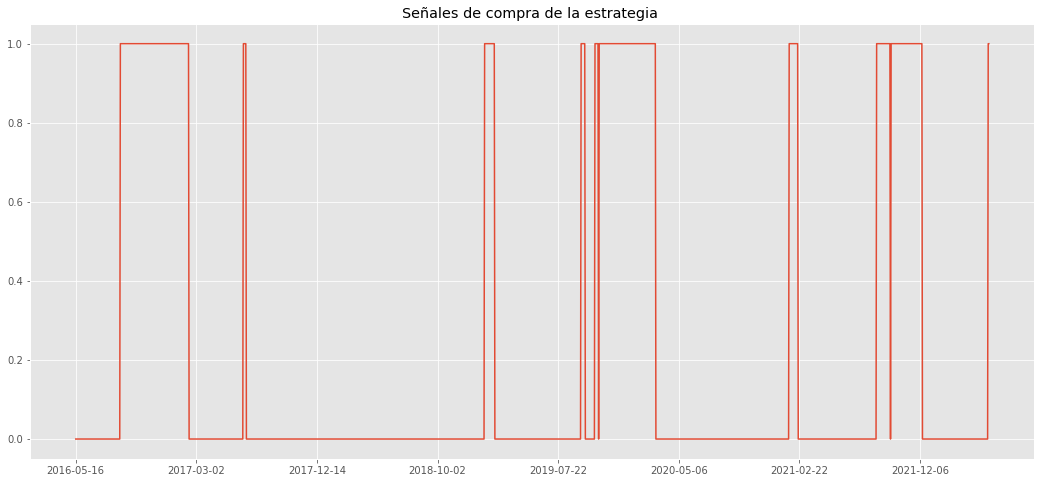

In [17]:
data['Senal'].plot(title = 'Señales de compra de la estrategia ' )
# Ploteando una parte
#data.loc['2010':'2022','Senal'].plot(title = 'Señales Regresión a la media ' +instrumento,xlim=('2010','2022'))

In [18]:
tiempo_final = time() 
 
tiempo_ejecucion = (tiempo_final - tiempo_inicial)/60
 
print ('El tiempo de ejecucion fue:',tiempo_ejecucion,"minutos") #En segundos

El tiempo de ejecucion fue: 9.347564220428467 minutos


In [19]:
data.loc['2011-01-04':'2019-11-04']

,Date,Senal,Price,Objetivo,ExitReason,Beneficio
2016-05-16,2016-05-16,0,92.690002,NaN,NaN,NaN
2016-05-17,2016-05-17,0,90.699997,NaN,NaN,NaN
2016-05-18,2016-05-18,0,89.879997,NaN,NaN,NaN
2016-05-19,2016-05-19,0,90.639999,NaN,NaN,NaN
2016-05-20,2016-05-20,0,90.769997,NaN,NaN,NaN
...,...,...,...,...,...,...
2019-10-29,2019-10-29,1,143.649994,NaN,NaN,NaN
2019-10-30,2019-10-30,1,145.970001,NaN,NaN,NaN
2019-10-31,2019-10-31,1,146.869995,NaN,NaN,NaN
2019-11-01,2019-11-01,1,143.070007,NaN,NaN,NaN


In [20]:
#Guardamos el resultado del analisis en un pickle
#dff.to_pickle("./primerBack_IBE.pkl")

***3.- Ingeniería de datos para calcular la bondad de la estrategia***

In [21]:

data['Dif_Close'] = data.Price.pct_change()
data['Retornos'] = data.Dif_Close * data.Senal.shift(1)   
data['Capital'] = (data.Retornos + 1).cumprod() * 100
    
rg.StrategyClass.dfLog=data  #Ojo a esta liena, no me cuadra.

#quant_j.salvarExcel(StrategyClass.dfLog, "log"+instrumento)   
#data.to_pickle('almacen')    #df = pd.read_pickle(file_name)

>Para calcular los retornos del sistema, calculamos la diferencia relativativa entre el precio de cierre y el del día anterior. Para posteriormente multiplicarlo por la señal que del día anterior que nos indicaba la posición a tomar (si estaba comprado, sumo beneficio).

In [22]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2022-05-13,2022-05-13,0,225.910004,NaN,NaN,NaN,0.015189,0.0,117.109056
2022-05-16,2022-05-16,0,229.320007,NaN,NaN,NaN,0.015095,0.0,117.109056
2022-05-17,2022-05-17,0,225.410004,NaN,NaN,NaN,-0.017050,-0.0,117.109056
2022-05-18,2022-05-18,1,207.690002,NaN,NaN,15.039211,-0.078612,-0.0,117.109056
2022-05-19,2022-05-19,1,205.119995,NaN,NaN,NaN,-0.012374,-0.012374,115.65992


In [23]:
data[60:]

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2016-08-10,2016-08-10,0,111.760002,NaN,NaN,NaN,0.013512,0.0,100.0
2016-08-11,2016-08-11,0,112.040001,NaN,NaN,NaN,0.002505,0.0,100.0
2016-08-12,2016-08-12,0,111.470001,NaN,NaN,NaN,-0.005087,-0.0,100.0
2016-08-15,2016-08-15,0,111.82,NaN,NaN,NaN,0.003140,0.0,100.0
2016-08-16,2016-08-16,0,111.5,NaN,NaN,NaN,-0.002862,-0.0,100.0
...,...,...,...,...,...,...,...,...,...
2022-05-13,2022-05-13,0,225.910004,NaN,NaN,NaN,0.015189,0.0,117.109056
2022-05-16,2022-05-16,0,229.320007,NaN,NaN,NaN,0.015095,0.0,117.109056
2022-05-17,2022-05-17,0,225.410004,NaN,NaN,NaN,-0.017050,-0.0,117.109056
2022-05-18,2022-05-18,1,207.690002,NaN,NaN,15.039211,-0.078612,-0.0,117.109056


>El capital, por comodidad, lo calcularemos en base 100, es decir como si iniciaramos la inversión con 100 unidades monetarias. Para su calculo arrastramos el producto acumulado de los retornos mas 1, multiplicados como dijimos por 100.

Pero para observar gráficamente la evolución del sistema necesitamos un gráfico con mas información. Para ello definimos una función que nos mostrará un gráfico con la evolución de nuestra estrategia, comparandola con la del activo. En un subgráfico se visualizará el drawdown del sistema, comparado de nuevo con el del activo. Y por útlimo las posiciones que toma el sistema.

In [24]:
def grafico (df):
    estudio = df.copy()
    
    DD_bh, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Dif_Close[60:], info = False) 
    
    DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Retornos.fillna(0), info = False) 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    fig.suptitle('Estrategia vs B & H', fontsize=20)

    #Primer plot analiza la evolcuion de una inversion de 100€ en buy&hold y la estrategia)
    ax1.plot(estudio.Capital)
    ax1.plot((estudio.Price) * (100/estudio.Price[1]))
    ax1.set_title('Capital')
    ax1.legend(['Estrategia','Buy & Hold'])

    ax2.plot(DD*100, c='0.5')
    ax2.plot(DD_bh*100, c='y')
    ax2.fill_between(DD.index, 0, DD*100, color='0.7')
    ax2.set_title('Drawdown')
    ax2.legend(['Estrategia','Buy & Hold'])

    ax3.plot(estudio.Senal, c='orange')
    #ax3.fill_between(estudio.index, 0, estudio.Senal*100, color='orange')
    ax3.set_title('Posición')

    plt.show()
    return

In [25]:
print(instrumento)

HSY


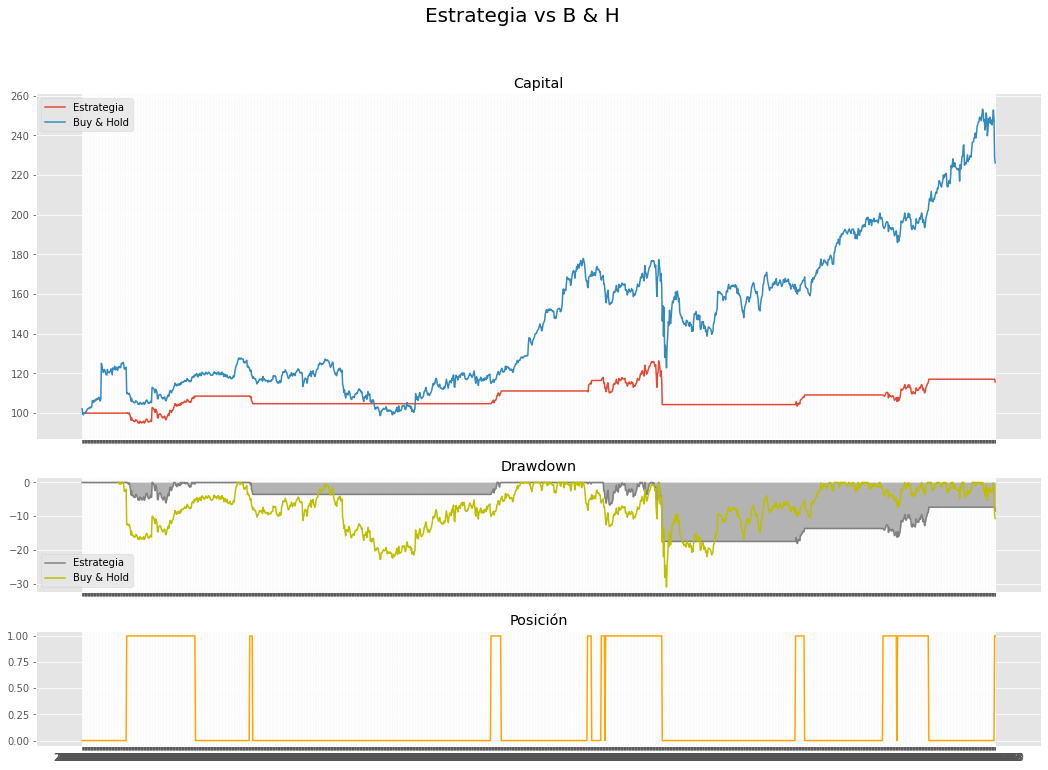

In [26]:
grafico(data)

---

In [27]:
#data[55:70]

---

# ANALISIS DEL SISTEMA

In [28]:
Beneficio_Bruto = data.Capital[-1] - data.Capital[1]
print ('Beneficio Bruto : {:.2f} €  con una inverison de 100€'.format(Beneficio_Bruto))

Beneficio Bruto : 15.66 €  con una inverison de 100€


In [29]:
#Rentabilidad anual compuesta. Calculamos lo que la inversion se ha incrementado cada año con el interes compuesto
CAGR = analisis.CAGR(data.Retornos)
print ('CAGR : {:.2f}%'.format(CAGR * 100))

CAGR : 2.45%


In [30]:
#Ratio calculado restando una rentabilidad segura a nuestra rentabilidad de estrategia y dividido por el riego (=volatilidad)
data.Retornos=data.Retornos.replace(0,np.e)  #Quito los cero (no sepuede hacer logariotmo de cero), pero no se que poner
Sharpe = CAGR / (np.log(data.Retornos + 1).std(skipna=True) * 252 ** 0.5)
print ('Sharpe : {:.3f}'.format(CAGR ))

Sharpe : 0.025


In [31]:
# Actualizo la excel con los economic
regreMedia.analisisEconomics(instrumento)

---


In [32]:
# 

### Cálculo esperanza matemática
 
 (%Aciertos * beneficioMedio )-(%Errores * perdidaMedia)
 Nos da idea el benefcio esperado por entrada

In [33]:
print("Numero operaciones con beneficio ->", 
      data[data['ExitReason'] > 0]['ExitReason'].count()) 
print("Numero operaciones con perdidas ->", 
      data[data['ExitReason'] < 0]['ExitReason'].count()) 
  
data[data['ExitReason']>0]['ExitReason'] 

data[data['Senal']>0][1:10]
data[data['Senal']>0].index[1]

Numero operaciones con beneficio -> 5
Numero operaciones con perdidas -> 11


'2016-08-31'

In [34]:
# ENTRADAS
print (data[(data['Senal']>0) & (data['Beneficio']>0)].index[0])
data[(data['Senal']>0) & (data['Beneficio']>0) ][0:5] 
# SALIDA PERDIDAS
print (data[(data['Senal'].shift(1) >0) & (data['ExitReason']== -1)].index[0])
data[(data['Senal'].shift(1) >0) & (data['ExitReason']== -1)][0:5]
# SALIDA GANANCIAS
data[(data['Senal'].shift(1) >0) & (data['ExitReason']== 1)][0:5]

2016-08-30
2017-06-29


,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2017-02-13,2017-02-13,0,108.209999,NaN,1,NaN,0.005482,0.005482,108.590063
2019-02-20,2019-02-20,0,110.68,NaN,1,NaN,0.009025,0.009025,111.166195
2019-09-24,2019-09-24,0,155.660004,NaN,1,NaN,0.015328,0.015328,116.471222
2021-02-18,2021-02-18,0,152.990005,NaN,1,NaN,0.011237,0.011237,109.161096
2021-12-10,2021-12-10,0,186.509995,NaN,1,NaN,0.016403,0.016403,117.109056


In [35]:
serieIndicesENTRADA=data[(data['Senal']>0) & (data['Beneficio']>0)].index

print(serieIndicesENTRADA.size)

serieIndicesENTRADA

serieIndicesEXIT=data[(data['ExitReason']==1) | (data['ExitReason']==-1)].index

print(serieIndicesEXIT.size)

#data['ExitReason'][serieIndicesEXIT[2]]

10
9


In [36]:
serieIndicesENTRADA

Index(['2016-08-30', '2017-06-22', '2019-01-25', '2019-09-13', '2019-10-16',
       '2019-10-25', '2021-01-27', '2021-08-24', '2021-09-28', '2022-05-18'],
      dtype='object')

In [37]:
#Cálculo Esperanza Matemática
countGanando=0
countPerdiendo=0

bolsaGanando=0
bolsaPerdiendo=0

for i in range(serieIndicesEXIT.size):
    if(data['ExitReason'][serieIndicesEXIT[i]] == -1):
        ref1  = data['Price'][serieIndicesEXIT[i]]
        ref2 = data['Price'][serieIndicesENTRADA[i]]
        #print ("-1",ref1, ref2)
        countPerdiendo= 1+countPerdiendo
        bolsaPerdiendo= bolsaPerdiendo + (ref1-ref2)

    
    if(data['ExitReason'][serieIndicesEXIT[i]] == 1):
        ref1  = data['Price'][serieIndicesEXIT[i]]
        ref2 = data['Price'][serieIndicesENTRADA[i]]
        print ("+1",ref1, ref2)
        countGanando= 1+countGanando
        bolsaGanando= bolsaGanando + (ref1-ref2)
    
#(%Aciertos * beneficioMedio )-(%Errores * perdidaMedia)

count=countGanando+countPerdiendo


print ("total ganado   --> ", bolsaGanando, "   numero operaciones ganando   ", countGanando)   
print ("total perdido -->", bolsaPerdiendo, "   numero operaciones perdiendo", countPerdiendo) 
print ("media perdiendo --> ", (bolsaPerdiendo/countPerdiendo), "  media ganando", (bolsaGanando/countGanando)) 


esperanza = (countGanando/count *(bolsaGanando/countGanando))+(countPerdiendo/count *(bolsaPerdiendo/countPerdiendo))
print("")
print("ESPERANZA MATEMATICA ES: ", esperanza)



+1 108.20999908447266 99.6500015258789
+1 110.68000030517578 104.30000305175781
+1 155.66000366210938 148.57000732421875
+1 152.99000549316406 146.19000244140625
+1 186.50999450683594 168.67999267578125
total ganado   -->  46.659996032714844    numero operaciones ganando    5
total perdido --> -24.740005493164062    numero operaciones perdiendo 4
media perdiendo -->  -6.185001373291016   media ganando 9.331999206542969

ESPERANZA MATEMATICA ES:  2.4355545043945317


---

In [38]:
serieIndicesEXIT

Index(['2017-02-13', '2017-06-29', '2019-02-20', '2019-09-24', '2019-10-24',
       '2020-03-12', '2021-02-18', '2021-09-27', '2021-12-10'],
      dtype='object')

In [39]:
serieIndicesENTRADA

Index(['2016-08-30', '2017-06-22', '2019-01-25', '2019-09-13', '2019-10-16',
       '2019-10-25', '2021-01-27', '2021-08-24', '2021-09-28', '2022-05-18'],
      dtype='object')